## This is colab version of model training process

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.__version__

'2.17.1'

In [ ]:
freq_bins = 1025
window_size = 9

def create_model():
    # Input
    inputs = Input(shape=(window_size, freq_bins))
    inputs = Reshape((window_size, freq_bins, 1))(inputs)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = ZeroPadding2D(padding=((0, 1), (0, 1)))(up7)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output
    final_conv = Conv2D(1, (3, 3), activation='relu', padding='same')(conv7)
    pooled = GlobalAveragePooling2D()(final_conv)
    outputs = Dense(freq_bins, activation='sigmoid')(pooled)

    model = Model(inputs=inputs, outputs=outputs, name="vocal_separator")
    return model


def create_model2():
    inputs = tf.keras.Input(shape=(window_size, freq_bins), name="input_audio")
    inputs = tf.keras.layers.Reshape((9, 1025, 1))(inputs)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(freq_bins, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="vocal_separator")
    return model

In [ ]:
model = create_model2()
model.summary()

Model: "vocal_separator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_61CLONE (InputLayer)    │ (None, 9, 1025, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 9, 1025, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 9, 1025, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 512, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1025)                │         263,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,041,345 (65.01 MB)

 Trainable params: 17,041,281 (65.01 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=['accuracy', "mse"]
)
epochs = 5

In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import stft
import os

FRAME_LENGTH = 1024
HOP_LENGTH = 512
SR = 44100
NUM_FRAMES = 25
TARGET_FRAME_INDEX = NUM_FRAMES // 2

def load_audio_with_scipy(file_path, target_sr=SR, frame_length=10 * SR):
    file_path = file_path.numpy().decode("utf-8")
    sr, audio = wavfile.read(file_path)
    if audio.dtype == np.int16:
        audio = audio / 32768.0
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    if sr != target_sr:
        from scipy.signal import resample
        audio = resample(audio, int(len(audio) * target_sr / sr))
    if len(audio) < frame_length:
        audio = np.pad(audio, (0, frame_length - len(audio)), mode='constant')
    else:
        audio = audio[:frame_length]
    return audio

def compute_spectrogram(audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH):
    _, _, Zxx = stft(audio, nperseg=frame_length, noverlap=frame_length - hop_length)
    return np.abs(Zxx)

# Создание бинарной маски
def create_binary_mask(vocal_spec, mix_spec, threshold=1):
    return (vocal_spec > threshold * mix_spec).astype(np.int32)

def get_window_from_spectrogram(spectrogram, start_idx, num_frames=NUM_FRAMES):
    num_freq_bins, num_time_frames = spectrogram.shape
    window = np.zeros((num_freq_bins, num_frames))

    start = max(0, start_idx)
    end = min(start_idx + num_frames, num_time_frames)

    insert_start = max(0, -start_idx)
    insert_end = insert_start + (end - start)

    window[:, insert_start:insert_end] = spectrogram[:, start:end]

    return window

def preprocess_pair_with_scipy(mix_path, vocal_path):
    mix_audio = load_audio_with_scipy(mix_path)
    vocal_audio = load_audio_with_scipy(vocal_path)

    mix_spec = compute_spectrogram(mix_audio)
    vocal_spec = compute_spectrogram(vocal_audio)
    mask = create_binary_mask(vocal_spec, mix_spec)

    X, y = [], []
    for i in range(-(NUM_FRAMES // 2), mix_spec.shape[1] - (NUM_FRAMES // 2)):
        window = get_window_from_spectrogram(mix_spec, i, NUM_FRAMES)
        target_frame = mask[:, max(0, min(i + TARGET_FRAME_INDEX, mask.shape[1] - 1))]
        X.append(window)
        y.append(target_frame)
    return np.array(X), np.array(y)

def tf_preprocess(mix_path, vocal_path):
    X, y = tf.py_function(
        func=preprocess_pair_with_scipy,
        inp=[mix_path, vocal_path],
        Tout=[tf.float32, tf.float32],
    )
    X.set_shape([None, 513, NUM_FRAMES])
    y.set_shape([None, 513])
    return X, y


mix_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')]
vocal_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')]
mix_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])
vocal_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])

mix_files_test = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][:25]
vocal_files_test = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][:25]
mix_files_test.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[30:40]])
vocal_files_test.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[30:40]])

mix_files_validation = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][25:]
vocal_files_validation = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][25:]
mix_files_validation.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[40:]])
vocal_files_validation.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[40:]])

file_dataset = tf.data.Dataset.from_tensor_slices((mix_files, vocal_files))
file_dataset_test = tf.data.Dataset.from_tensor_slices((mix_files_test, vocal_files_test))
file_dataset_validation = tf.data.Dataset.from_tensor_slices((mix_files_validation, vocal_files_validation))

train_dataset = file_dataset.map(tf_preprocess)
test_dataset = file_dataset_test.map(tf_preprocess)
valid_dataset = file_dataset_validation.map(tf_preprocess)

BATCH_SIZE = 32
epochs=20
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

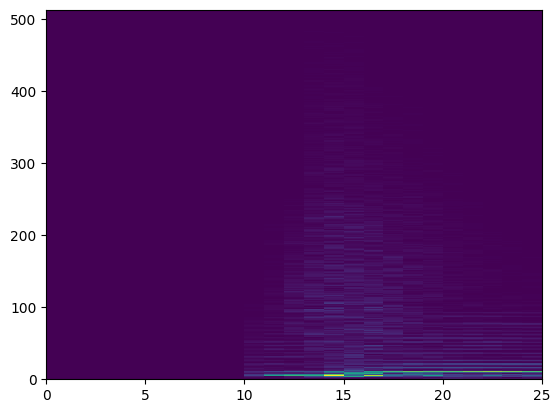

In [33]:
from matplotlib import pyplot as plt
for i in train_dataset.take(5):

  plt.pcolormesh(i[0][20].numpy())

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Conv2DTranspose,
    concatenate,
    GlobalAveragePooling2D,
    Dense,
    Flatten,
    Reshape,
    ZeroPadding2D,
    Dropout,
    BatchNormalization,
    Activation,
)

freq_bins = 513


def unet(input_shape=(freq_bins, NUM_FRAMES, 1)):

    # Input
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (5, 5), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (5, 5), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    # Bottleneck
    conv4 = Conv2D(512, (5, 5), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (5, 5), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)

    # Decoder
    up5 = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same")(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (5, 5), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (5, 5), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)

    up6 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same")(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (5, 5), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (5, 5), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same")(conv6)
    up7 = ZeroPadding2D(padding=((0, 1), (0, 1)))(up7)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)

    # Output
    final_conv = Conv2D(1, (5, 5), activation='relu', padding='same')(conv7)
    final_conv = BatchNormalization()(final_conv)
    final_conv = Activation("relu")(final_conv)
    # pooled = GlobalAveragePooling2D()(final_conv)
    pooled = Flatten()(final_conv)
    pooled = Dense(256, activation="relu")(pooled)
    pooled = Dropout(0.2)(pooled)
    outputs = Dense(freq_bins, activation='sigmoid')(pooled)

    model = Model(inputs=inputs, outputs=outputs, name="vocal_separator")
    return model

In [4]:
def dataset_length(dataset):
    return sum(1 for _ in dataset)

train_size = dataset_length(train_dataset)
val_size = dataset_length(val_dataset)

steps_per_epoch = train_size
validation_steps = val_size

<ipython-input-2-d07222566422>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


In [5]:
validation_steps

943

In [6]:
steps_per_epoch

3505

In [3]:
model = unet()
model.summary()

Model: "vocal_separator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 513, 25, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 513, 25, 64)    │          1,664 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 513, 25, 64)    │        102,464 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 513, 25, 64)    │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 513, 25, 64)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 12, 64)    │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 12, 64)    │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 12, 128)   │        204,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 12, 128)   │        409,728 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 12, 128)   │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 12, 128)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 6, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 6, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 6, 256)    │        819,456 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 6, 256)    │      1,638,656 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 6, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 6, 256)    │              0 │ batch_normalization_2… │
├──────────────────────

 Total params: 27,186,246 (103.71 MB)

 Trainable params: 27,182,404 (103.69 MB)

 Non-trainable params: 3,842 (15.01 KB)

In [4]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy']
)
epochs=20

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_dataset.repeat(epochs),
    validation_data=val_dataset.repeat(epochs),
    epochs=epochs,
    steps_per_epoch=3505,
    validation_steps=943,
    verbose=1
  )

Epoch 1/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.0177 - loss: 1.2460

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


3505/3505 ━━━━━━━━━━━━━━━━━━━━ 975s 263ms/step - accuracy: 0.0177 - loss: 1.2460 - val_accuracy: 3.9767e-04 - val_loss: 1.2686
Epoch 2/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 905s 258ms/step - accuracy: 0.0016 - loss: 1.2298 - val_accuracy: 3.9767e-04 - val_loss: 1.3335
Epoch 3/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 905s 258ms/step - accuracy: 0.0017 - loss: 1.2254 - val_accuracy: 3.9767e-04 - val_loss: 1.2422
Epoch 4/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 906s 258ms/step - accuracy: 7.4679e-04 - loss: 1.2215 - val_accuracy: 3.9767e-04 - val_loss: 1.2575
Epoch 5/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 906s 258ms/step - accuracy: 7.2502e-04 - loss: 1.2303 - val_accuracy: 3.9767e-04 - val_loss: 1.2610
Epoch 6/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 906s 258ms/step - accuracy: 0.0011 - loss: 1.2203 - val_accuracy: 3.9767e-04 - val_loss: 1.2398
Epoch 7/20
 948/3505 ━━━━━━━━━━━━━━━━━━━━ 10:15 241ms/step - accuracy: 7.1811e-04 - loss: 1.1898

In [11]:
model.save("drive/MyDrive/saved_models/unet_model2.keras")

In [12]:
model.evaluate(test_dataset)

    647/Unknown 124s 186ms/step - accuracy: 0.0031 - loss: 0.2355

<ipython-input-2-d07222566422>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


943/943 ━━━━━━━━━━━━━━━━━━━━ 173s 180ms/step - accuracy: 0.0027 - loss: 0.2289


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.2246417999267578, 0.0016238070093095303]

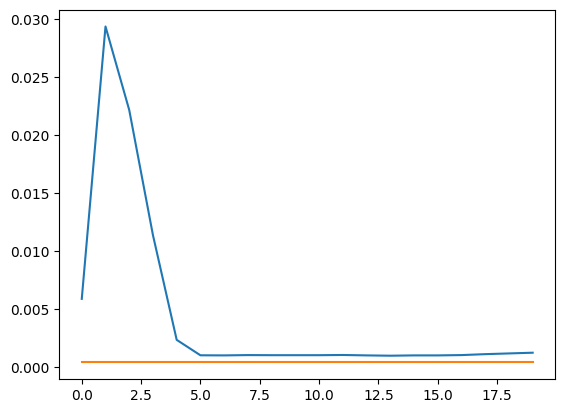

In [18]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [19]:
history.history['loss']

[0.3170861601829529,
 0.3024230897426605,
 0.3024812936782837,
 0.3024856746196747,
 0.3024653196334839,
 0.3023945987224579,
 0.30225762724876404,
 0.3022211194038391,
 0.3022105097770691,
 0.3021070659160614,
 0.30212005972862244,
 0.30261996388435364,
 0.30210214853286743,
 0.3020906150341034,
 0.30211499333381653,
 0.30211880803108215,
 0.3020384609699249,
 0.3021192252635956,
 0.3021112084388733,
 0.3020804524421692]